In [1]:
# Imports
import math
import random

from argparse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import PIL
import pyvista as pv
import torch

from mpl_toolkits.mplot3d import Axes3D
from plyfile import PlyData, PlyElement
from vtk import vtkMatrix4x4, vtkMatrix3x3

from arguments import ModelParams, PipelineParams, OptimizationParams
from gaussian_renderer import render
from scene import GaussianModel
from scene.cameras import Camera
from scene.dataset_readers import fetchPly
from utils.general_utils import PILtoTorch

In [2]:
# Setup some basic args without actually passing input
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument("--ip", type=str, default="127.0.0.1")
parser.add_argument("--port", type=int, default=6009)
parser.add_argument("--debug_from", type=int, default=-1)
parser.add_argument("--detect_anomaly", action="store_true", default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--save_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[])
parser.add_argument("--start_checkpoint", type=str, default=None)
args = parser.parse_args("")
args.save_iterations.append(args.iterations)

dataset = lp.extract(args)
training_args = op.extract(args)
pipe = pp.extract(args)
pipe.debug = True

In [3]:
def qvec2rotmat(qvec):
    return np.array(
        [
            [
                1 - 2 * qvec[2] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
                2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2],
            ],
            [
                2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1],
            ],
            [
                2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
                2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[2] ** 2,
            ],
        ]
    )


def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))


def focal2fov(focal, pixels):
    return 2 * math.atan(pixels / (2 * focal))

In [4]:
# Instantiate the plotter once
def init_pv_plotter(path, pcd, width, height):
    mesh = pv.read(path)
    min_vals = np.min(mesh.points, axis=0)
    max_vals = np.max(mesh.points, axis=0)
    mesh.points = (mesh.points - min_vals) / (max_vals - min_vals)
    plotter = pv.Plotter(off_screen=True)
    plotter.add_mesh(mesh, show_scalar_bar=False, cmap=plt.cm.coolwarm_r)
    offset = list(plotter.camera.focal_point)
    # offset[2] -= 1000
    print(f"offset = {offset}")
    for i, _ in enumerate(mesh.points):
        mesh.points[i] = mesh.points[i] - offset
        pcd.points[i] = (pcd.points[i] - min_vals) / (max_vals - min_vals)
        pcd.points[i] = pcd.points[i] - offset
    mesh.points
    plotter.add_mesh(mesh, show_scalar_bar=False, cmap=plt.cm.coolwarm_r)
    plotter.window_size = [width, height]
    plotter.view_xy()
    return plotter, pcd


# Just used for getting the VTK matrices into a ndarray
def arrayFromVTKMatrix(vmatrix):
    if isinstance(vmatrix, vtkMatrix4x4):
        matrixSize = 4
    elif isinstance(vmatrix, vtkMatrix3x3):
        matrixSize = 3
    else:
        raise RuntimeError("Input must be vtk.vtkMatrix3x3 or vtk.vtkMatrix4x4")
    narray = np.eye(matrixSize)
    vmatrix.DeepCopy(narray.ravel(), vmatrix)
    return narray.astype(np.float32)


# Generates a new Camera() object
def get_new_vtk_camera(plotter, elevation, azimuth):
    camera = plotter.camera
    position = list(camera.position)
    # position[2] *= 2
    camera.position = position
    camera.elevation = elevation
    camera.azimuth = azimuth

    # # Set a new random camera position along a sphere centered on the model
    # current_position = np.array(camera.position)
    # focal_point = np.array(camera.focal_point)

    # radius = np.linalg.norm(current_position - focal_point)

    # # z = 0
    # # while abs(z) < radius * 0.8:
    # theta = np.random.uniform(0, 2 * np.pi)
    # phi = np.random.uniform(0, np.pi)
    # x = radius * np.sin(phi) * np.cos(theta) + focal_point[0]
    # y = radius * np.sin(phi) * np.sin(theta) + focal_point[1]

    # camera.position = (x, y, np.random.choice([radius, -radius]))

    # Render the model, convert it to a PIL Image
    image_array = PIL.Image.fromarray(plotter.screenshot(return_img=True)).convert(
        "RGBA"
    )

    resized_image_rgb = PILtoTorch(image_array, image_array.size, "cuda")
    gt_image = resized_image_rgb[:3, ...]

    loaded_mask = None
    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    mvt_matrix = np.linalg.inv(arrayFromVTKMatrix(camera.GetModelViewTransformMatrix()))
    mvt_matrix[:3, 1:3] *= -1

    rotation = mvt_matrix[:3, :3].T
    translation = mvt_matrix[:3, 3]

    width, height = plotter.window_size
    FovY = np.radians(camera.view_angle)
    FovX = focal2fov(fov2focal(FovY, height), width)

    proj_matrix = arrayFromVTKMatrix(
        camera.GetCompositeProjectionTransformMatrix(width / height, 0.01, 1000.01)
    )

    cx = 0
    cy = 0

    # Instantiate a new Camera object using these computed values
    new_camera = Camera(
        colmap_id=1,
        R=rotation,
        T=translation,
        FoVx=FovX,
        FoVy=FovY,
        cx=cx,
        cy=cy,
        image=gt_image,
        gt_alpha_mask=loaded_mask,
        image_name="",
        uid=0,
        data_device="cuda",
    )

    # mvt_matrix[2, 3] = abs(mvt_matrix[2, 3])
    proj_matrix[1, :] = -proj_matrix[1, :]
    proj_matrix[2, :] = -proj_matrix[2, :]

    if camera.position[1] < 0:
        mvt_matrix[2, 1] *= -1
    mvt_matrix[2, 3] = abs(mvt_matrix[2, 3])

    new_camera.from_vtk(mvt_matrix, proj_matrix)

    plotter.close()

    # Debug prints
    # print(f"mvt_matrix[2, 1]={mvt_matrix[2, 1]}")
    # print(f"mvt_matrix[2, 3]={mvt_matrix[2, 3]}")
    # print(f"radius={radius}")
    # print("new_camera")

    # print(f"roll={roll}")
    # print(f"view_angle={camera.view_angle}")
    # print(f"orientation={camera.GetOrientation()}")
    # print(f"orientationWXYZ={camera.GetOrientationWXYZ()}")
    # print(f"uid={new_camera.uid}")
    # print(f"colmap_id={new_camera.colmap_id}")
    # print(f"R={new_camera.R}")
    # print(f"T={new_camera.T}")
    # print(
    #     f"modelview={np.linalg.inv(arrayFromVTKMatrix(camera.GetModelViewTransformMatrix()))}"
    # )
    # print(f"eye={arrayFromVTKMatrix(camera.GetEyeTransformMatrix())}")
    # print(f"FoVx={new_camera.FoVx}")
    # print(f"FoVy={new_camera.FoVy}")
    # print(f"cx={new_camera.cx}")
    # print(f"cy={new_camera.cy}")
    # print(f"image_name={new_camera.image_name}")
    # print(f"data_device={new_camera.data_device}")
    # print(f"image_width={new_camera.image_width}")
    # print(f"image_height={new_camera.image_height}")
    # print(f"zfar={new_camera.zfar}")
    # print(f"znear={new_camera.znear}")
    # print(f"trans={new_camera.trans}")
    # print(f"scale={new_camera.scale}")
    # print(f"world_view_transform={new_camera.world_view_transform}")
    # print(f"projection_matrix={new_camera.projection_matrix}")
    # print(f"full_proj_transform={new_camera.full_proj_transform}")

    # print(f"focal_disk={camera.GetFocalDisk()}")
    # print(f"view_up={camera.up}")
    # print(f"direction={camera.direction}")
    # print(f"window_center={camera.GetWindowCenter()}")

    # print(f"azimuth={camera.azimuth}")
    # print(f"elevation={camera.elevation}")
    # print(f"mvt_matrix={mvt_matrix}")
    # print(f"proj_matrix={proj_matrix}")
    # print(f"position={camera.position}")
    # print(f"center={new_camera.camera_center}")
    # print(f"focal_point={camera.focal_point}")

    return new_camera, camera.position

In [5]:
# Generate a new synthetic viewpoint and feed the camera parameters to the Gaussian renderer
from scene.dataset_readers import storePly


bg_color = [1, 1, 1]
bg = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

# Can change the image resolution to whatever you'd like, but 1080p is fast
width = 1600
height = 1063


def plot_comparison(gt_image, g_image, elevation, azimuth, position):
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    axes[0].imshow(
        gt_image,
    )
    axes[0].set_title("VTK")
    axes[0].axis("off")

    axes[1].imshow(
        g_image,
    )
    axes[1].set_title("Gaussian")
    axes[1].axis("off")
    axes[2].imshow(
        gt_image,
        alpha=0.5,
    )
    axes[2].imshow(
        g_image,
        alpha=0.5,
    )
    axes[2].set_title("Combined")
    axes[2].axis("off")

    x, y, z = position
    plt.savefig(f"test-imgs/azi_{azimuth}_ele_{elevation}_x_{int(x)}_y_{int(y)}_z_{int(z)}.png")


def new_comparison(elevation, azimuth):
    # Load a .ply dataset as a Gaussian model
    sh_degree = 3
    gaussians = GaussianModel(sh_degree)

    ply_path = "data/bonsai/data.ply"
    pcd = fetchPly(ply_path)
    plotter, new_pcd = init_pv_plotter(ply_path, pcd, width, height)
    storePly("data/bonsai/converted.ply", new_pcd.points, new_pcd.colors)
    spatial_lr_scale = 0
    gaussians.create_from_pcd(new_pcd, spatial_lr_scale)
    gaussians.training_setup(training_args)
    viewpoint_cam, position = get_new_vtk_camera(plotter, elevation, azimuth)
    render_pkg = render(viewpoint_cam, gaussians, pipe, bg)
    gaussian_image = render_pkg["render"]

    gt_image = viewpoint_cam.original_image.cpu().detach().numpy().transpose(1, 2, 0)
    g_image = gaussian_image.cpu().detach().numpy().transpose(1, 2, 0)

    plot_comparison(gt_image, g_image, elevation, azimuth, position)

offset = [0.5, 0.5, 0.5]
Number of points at initialisation :  312272
offset = [0.5, 0.5, 0.5]
Number of points at initialisation :  312272


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06077046..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.06077046..1.0000001].


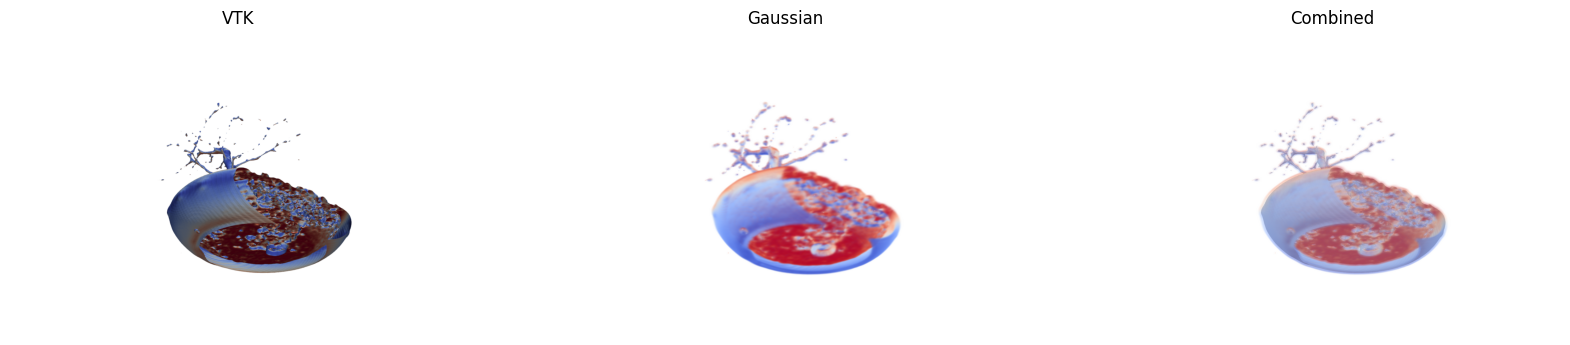

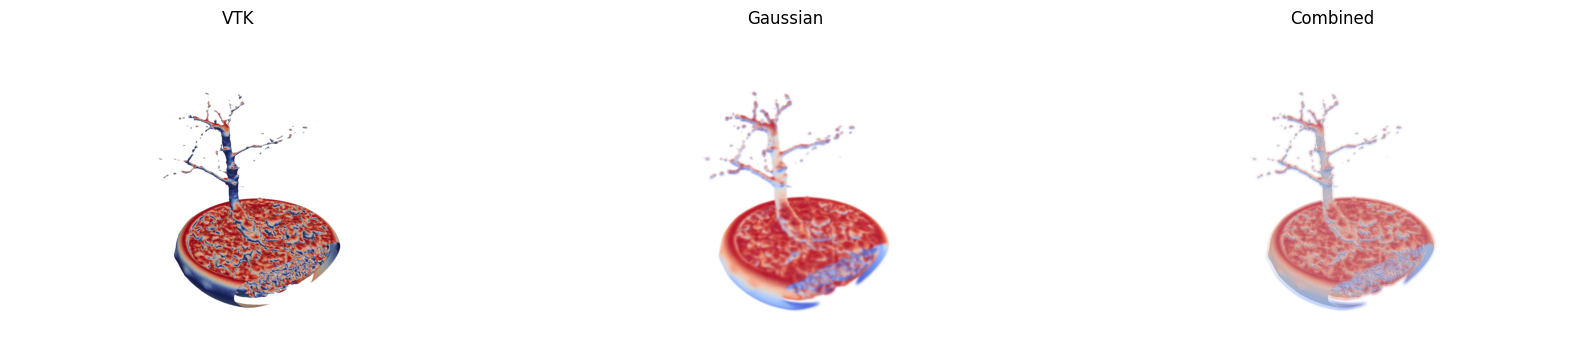

In [10]:
# bad = [6, 28, 46, 49, 62, 63]
azimuth_steps = 18
elevation_steps = 8
azimuth_range = range(0, 360, 360 // azimuth_steps)
elevation_range = range(-70, 70, 140 // elevation_steps)
# for elevation in elevation_range:
#         for azimuth in azimuth_range:
#             new_comparison(elevation, azimuth)
for elevation in [-30, 30]:
        for azimuth in [-36]:
            new_comparison(elevation, azimuth)
# for i in bad:
#     new_comparison(i)
# for i in range(30, 61):
#     new_comparison(i)

In [7]:
num_pts = 100_000
xyz = np.random.random((num_pts, 3)) * 2.6 - 1.3

xyz

array([[ 0.63027164, -0.79810802, -0.17720181],
       [ 1.29505888, -0.74948197,  0.92878561],
       [ 0.04455392, -0.34417777, -1.00944941],
       ...,
       [ 0.55685599, -0.09586249,  0.21004117],
       [ 0.5310759 , -1.15970428,  0.66046201],
       [-0.11876557, -0.83581909,  0.90825292]])